In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os, time
print(os.getcwd())
readStart=time.time()

# Edit the file name to make sure you are pointing to the right file.
dfPatProc = pd.read_csv(r'../data/03_processed/ProceduresPatients-20210225-ems-raw-v04.csv', 
                        na_values=['NA'])

# Stop the clock and calculate read time
readStop=time.time()
readTime=readStop-readStart
readMin=np.floor(readTime/60)
readSec=np.floor(readTime-(readMin*60))
print("The file was read in {0:.0f} minutes and {1:.0f} seconds.".format(readMin,readSec))

dfPatProc.shape

E:\github\ems-analytics\notebooks
The file was read in 0 minutes and 0 seconds.


(170072, 19)

In [3]:
dfPatProc.columns

Index(['Unnamed: 0', 'PatientId', 'FRDPersonnelID', 'PatientOutcome',
       'PatientGender', 'DispatchTime', 'FRDPersonnelGender',
       'FRDPersonnelStartDate', 'Dim_Procedure_PK', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', '_PK', 'TenureMonths',
       'PatientOutcomeCode', 'PatientGenderCode', 'PatientGender_Female',
       'PatientGender_Male', 'PatientGender_Unknown (Unable to Determine)',
       'ProviderGenderCode'],
      dtype='object')

need to reset the descriptions for Procedure Code 427753009 to be a common value of "Airway - Supraglottic Airway" instead of "Airway - Supraglottic Airway (King, i-Gel)" and "Airway - Supraglottic Airway (i-Gel, King)"

In [4]:
dfPatProc.replace(to_replace=['Airway - Supraglottic Airway (King, i-Gel)','Airway - Supraglottic Airway (i-Gel, King)'],
                  value='Airway - Supraglottic Airway',
                  inplace=True)

In [5]:
dfPatProc_freq = dfPatProc.groupby(['TenureMonths',
                                    'Procedure_Performed_Code',
                                    'Procedure_Performed_Description']).size().to_frame(name='Procedure_Count').reset_index()

dfPatProc_freq.shape

(8810, 4)

In [6]:
dfPatProc_freq.head(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
0,-27,398041008,MS - Cervical Spinal Restriction of Motion,1
1,-20,7443007,Airway - Oropharyngeal Insertion,1


In [7]:
dfPatProc_freq.tail(2)

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
8808,440,425447009,Resp - Assist Ventilation - BVM Via Mask,2
8809,453,392230005,IV Start - Extremity Vein (arm or leg),1


In [8]:
dfPatProc_freq.columns

Index(['TenureMonths', 'Procedure_Performed_Code',
       'Procedure_Performed_Description', 'Procedure_Count'],
      dtype='object')

<AxesSubplot:title={'center':'Provider Tenure and Procedures Performed'}, xlabel='Provider Tenure', ylabel='Procedure'>

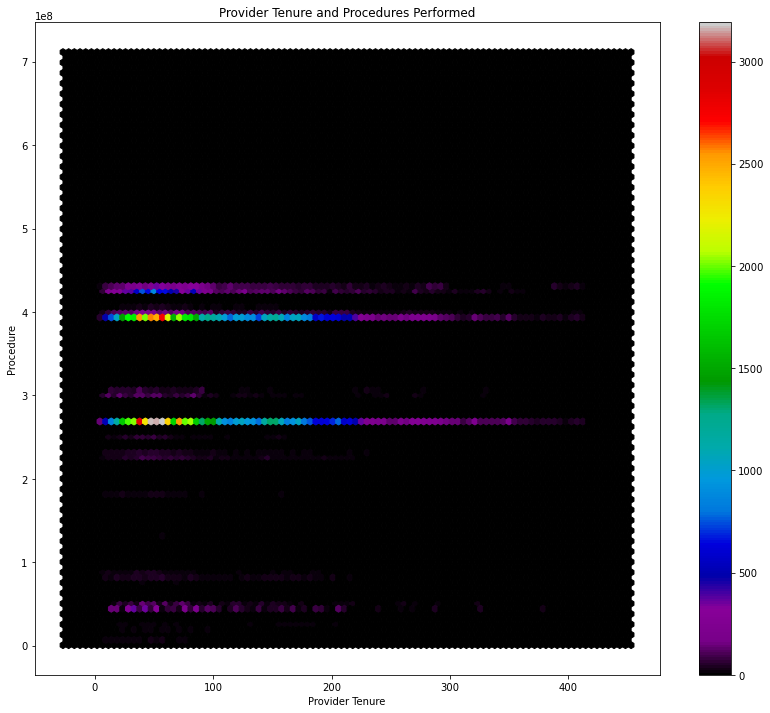

In [9]:
dfPatProc.plot.hexbin(x='TenureMonths', 
                       y='Procedure_Performed_Code', 
                       #C='Procedure_Performed_Description',
                       #reduce_C_function=np.count,
                       gridsize=100,
                       cmap="nipy_spectral",
                       #cmap="viridis",
                       xlabel="Provider Tenure",
                       ylabel="Procedure",
                       title="Provider Tenure and Procedures Performed",
                       figsize=(14,12),
                       sharex=False)

<function matplotlib.pyplot.show(close=None, block=None)>

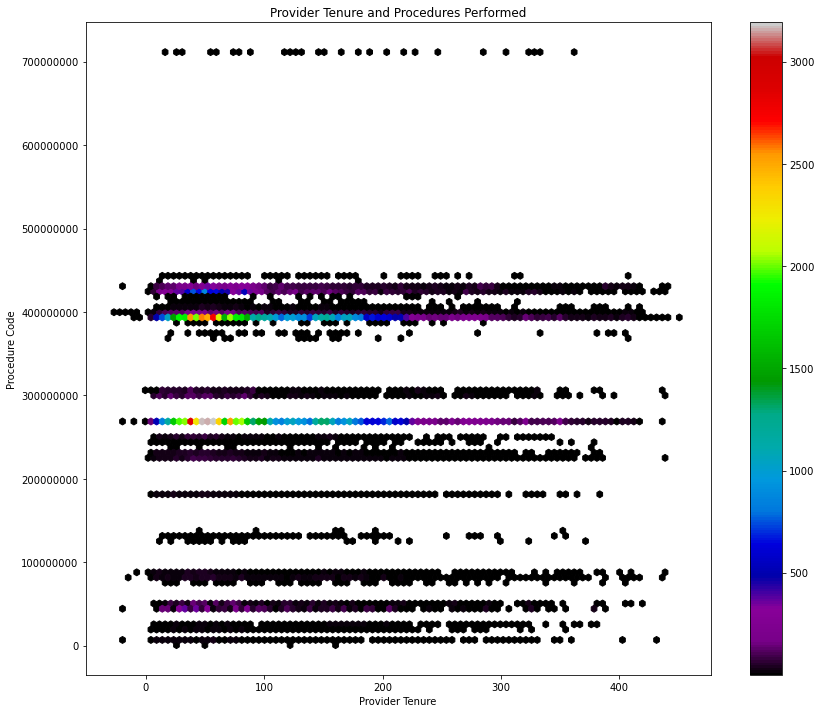

In [10]:
# in order to get the procedure code to show in the y-axis, need to format the values as strings instead of numbers
hb = dfPatProc_freq.plot.hexbin(
                       x='TenureMonths', 
                       y='Procedure_Performed_Code', 
                       C='Procedure_Count',
                       reduce_C_function=np.sum,
                       gridsize=100,
                       cmap="nipy_spectral",
                       xlabel="Provider Tenure",
                       ylabel="Procedure Code",
                       title="Provider Tenure and Procedures Performed",
                       figsize=(14,12),
                       sharex=False
)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))

plt.show

The hex bin plots of dfPatProc and dfPatProc_freq show the same binning results.  The difference is that the binning of dfPatProc_freq makes use of 3 attributes from the dataframe.  Using x, y, and C means that the reduce_C_function now comes into play and it is the reason for all of the white showing - it is where there is no sum to show.

In [11]:
dfPatProc_freq.describe(include='all')

,TenureMonths,Procedure_Performed_Code,Procedure_Performed_Description,Procedure_Count
count,8810.000000,8.810000e+03,8810,8810.000000
unique,NaN,NaN,67,NaN
top,NaN,NaN,IV Start - Extremity Vein (arm or leg),NaN
freq,NaN,NaN,424,NaN
mean,152.577639,2.897080e+08,NaN,19.304427
std,102.994886,1.532866e+08,NaN,66.200814
min,-27.000000,6.730050e+05,NaN,1.000000
25%,66.000000,1.826920e+08,NaN,1.000000
50%,137.000000,3.720450e+08,NaN,3.000000
75%,220.000000,4.262200e+08,NaN,7.000000


In [12]:
dfPatProc_freq[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,8810.000000,8810.000000
mean,152.577639,19.304427
std,102.994886,66.200814
min,-27.000000,1.000000
25%,66.000000,1.000000
50%,137.000000,3.000000
75%,220.000000,7.000000
max,453.000000,697.000000


In [13]:
dfPatProc_freq[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,8810
unique,67
top,IV Start - Extremity Vein (arm or leg)
freq,424


array([[<AxesSubplot:title={'center':'TenureMonths'}>]], dtype=object)

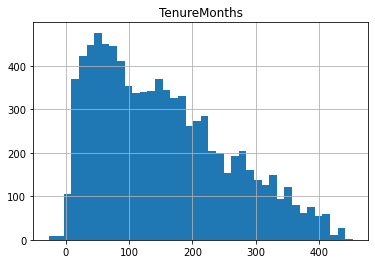

In [14]:
dfPatProc_freq.hist(column='TenureMonths', bins=40)

array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

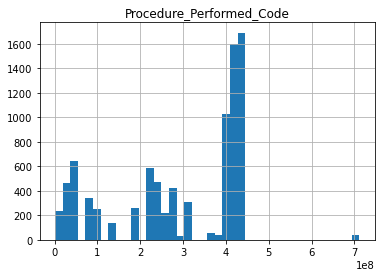

In [15]:
dfPatProc_freq.hist(column='Procedure_Performed_Code', bins=40)

Run again, but now drop the "time traveler" (negative tenure) rows

In [16]:
dfPatProc_freq.shape

(8810, 4)

In [17]:
dfPatProc_freq2 = dfPatProc_freq[(dfPatProc_freq['TenureMonths'] >= 0)]

dfPatProc_freq2.shape

(8793, 4)

Reduced row count by 17 "time traveler" rows

Now, rerun the hex bin plot now that the "time traveler" bins are removed

<function matplotlib.pyplot.show(close=None, block=None)>

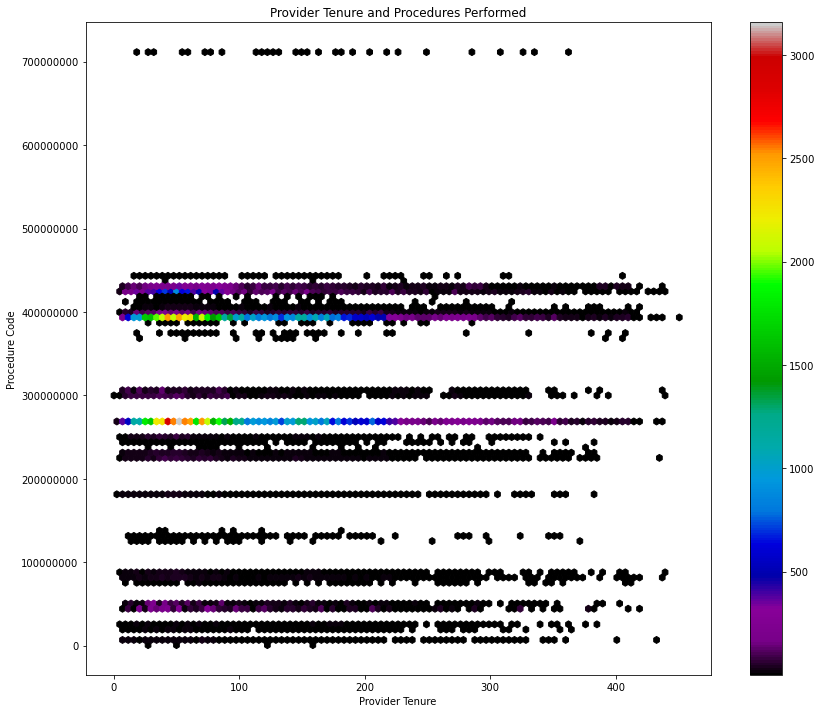

In [18]:
# in order to get the procedure code to show in the y-axis, need to format the values as strings instead of numbers
hb = dfPatProc_freq2.plot.hexbin(
                       x='TenureMonths', 
                       y='Procedure_Performed_Code', 
                       C='Procedure_Count',
                       reduce_C_function=np.sum,
                       gridsize=100,
                       #cmap="viridis",
                       cmap="nipy_spectral",
                       xlabel="Provider Tenure",
                       ylabel="Procedure Code",
                       title="Provider Tenure and Procedures Performed",
                       figsize=(14,12),
                       sharex=False
)

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))

plt.show

Rerun descriptive statistics and histograms to see what difference including the "time traveler" tenure incurred

In [19]:
dfPatProc_freq2[['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,8793.000000,8793.000000
mean,152.901285,19.339361
std,102.830456,66.260006
min,0.000000,1.000000
25%,66.000000,1.000000
50%,137.000000,3.000000
75%,220.000000,7.000000
max,453.000000,697.000000


In [20]:
dfPatProc_freq2[['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,8793
unique,67
top,IV Start - Extremity Vein (arm or leg)
freq,421


array([[<AxesSubplot:title={'center':'TenureMonths'}>]], dtype=object)

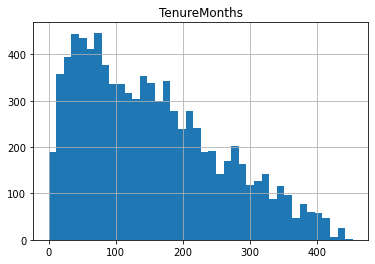

In [21]:
dfPatProc_freq2.hist(column='TenureMonths', bins=40)

array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

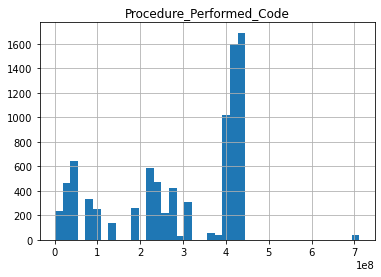

In [22]:
dfPatProc_freq2.hist(column='Procedure_Performed_Code', bins=40)

What are the top 10 procedures overall?

In [23]:
dfPatProc_freq2.groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,66972
392230005,IV Start - Extremity Vein (arm or leg),59835
46825001,Electrocardiographic monitoring,4755
398041008,MS - Cervical Spinal Restriction of Motion,4693
422618004,Assess - Assessment of Patient,4192
302789003,Assess - Blood Glucose Level (BGL),3590
428803005,CV - ECG - Limb Lead Monitoring,3114
425543005,Assess - Capnography (ETCO2),2876
430824005,IO Start - Intraosseous Access,1857


Going to look at tenure less than or equal to 100 months as highest frequency appears to be around 50 months

In [24]:
#dfPatProc_tenure = dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)]

#dfPatProc_tenure.shape
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)].shape

(3361, 4)

In [25]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)][['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,3361.000000,3361.000000
mean,52.940494,29.905980
std,26.465938,94.333732
min,0.000000,1.000000
25%,31.000000,2.000000
50%,53.000000,4.000000
75%,75.000000,11.000000
max,100.000000,697.000000


In [26]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)][['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,3361
unique,67
top,CV - ECG - 12 Lead Obtained
freq,101


array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

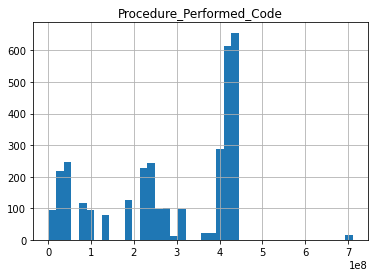

In [27]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)].hist(column='Procedure_Performed_Code', bins=40)

What are the top 10 procedures by count for procedures performed by providers with 100 or less months of tenure?

In [28]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 100)].groupby(['Procedure_Performed_Code',
     'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,39043
392230005,IV Start - Extremity Vein (arm or leg),33944
422618004,Assess - Assessment of Patient,3596
46825001,Electrocardiographic monitoring,3035
398041008,MS - Cervical Spinal Restriction of Motion,2621
302789003,Assess - Blood Glucose Level (BGL),2571
425543005,Assess - Capnography (ETCO2),1998
428803005,CV - ECG - Limb Lead Monitoring,1966
430824005,IO Start - Intraosseous Access,1121


What are the top 10 procedures by count for procedures performed by providers with 52 or 53 months (mean = 52.9) of tenure?

In [29]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] >= 52) & 
                (dfPatProc_freq2['TenureMonths'] <= 53)].groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,1221
392230005,IV Start - Extremity Vein (arm or leg),925
422618004,Assess - Assessment of Patient,164
46825001,Electrocardiographic monitoring,112
428803005,CV - ECG - Limb Lead Monitoring,86
425543005,Assess - Capnography (ETCO2),84
398041008,MS - Cervical Spinal Restriction of Motion,81
302789003,Assess - Blood Glucose Level (BGL),58
225358003,Wound Care - General,39


Going to look at procedures of the highest (greater than or equal to 300 months) and lowest (less than or equal to 24 months) tenure

In [30]:
#dfPatProc_tenure2 = dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24) | (dfPatProc_freq2['TenureMonths'] >= 300)]

#dfPatProc_tenure2.shape
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24) | (dfPatProc_freq2['TenureMonths'] >= 300)].shape

(1566, 4)

Check the breakdown for the low tenure

In [31]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24)][['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,611.000000,611.000000
mean,14.998363,18.034370
std,5.860258,52.781552
min,0.000000,1.000000
25%,10.000000,2.000000
50%,16.000000,4.000000
75%,20.000000,9.000000
max,24.000000,405.000000


In [32]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24)][['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,611
unique,55
top,CV - ECG - 12 Lead Obtained
freq,25


In [33]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24)].groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,3992
392230005,IV Start - Extremity Vein (arm or leg),3478
302789003,Assess - Blood Glucose Level (BGL),555
398041008,MS - Cervical Spinal Restriction of Motion,362
46825001,Electrocardiographic monitoring,336
422618004,Assess - Assessment of Patient,266
425543005,Assess - Capnography (ETCO2),229
425447009,Resp - Assist Ventilation - BVM Via Mask,206
428803005,CV - ECG - Limb Lead Monitoring,162


array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

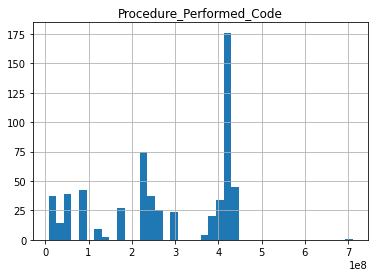

In [34]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] <= 24)].hist(column='Procedure_Performed_Code', bins=40)

Check the breakdown for the high tenure

In [35]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] >= 300)][['TenureMonths','Procedure_Count']].describe()

,TenureMonths,Procedure_Count
count,955.000000,955.000000
mean,351.373822,5.213613
std,35.859520,7.909500
min,300.000000,1.000000
25%,322.000000,1.000000
50%,346.000000,1.000000
75%,379.000000,5.000000
max,453.000000,58.000000


In [36]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] >= 300)][['Procedure_Performed_Description']].describe(include='all')

,Procedure_Performed_Description
count,955
unique,49
top,IV Start - Extremity Vein (arm or leg)
freq,126


In [37]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] >= 300)].groupby(['Procedure_Performed_Code',
                          'Procedure_Performed_Description'])[['Procedure_Count']].sum().nlargest(10,['Procedure_Count'])

,,Procedure_Count
Procedure_Performed_Code,Procedure_Performed_Description,
268400002,CV - ECG - 12 Lead Obtained,2110
392230005,IV Start - Extremity Vein (arm or leg),1434
428803005,CV - ECG - Limb Lead Monitoring,239
398041008,MS - Cervical Spinal Restriction of Motion,155
422618004,Assess - Assessment of Patient,146
46825001,Electrocardiographic monitoring,125
302789003,Assess - Blood Glucose Level (BGL),106
426498007,MS - Full Spinal Restriction of Motion,88
426220008,CV - Defibrillation - Manual,67


array([[<AxesSubplot:title={'center':'Procedure_Performed_Code'}>]],
      dtype=object)

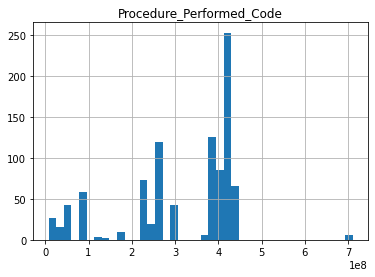

In [38]:
dfPatProc_freq2[(dfPatProc_freq2['TenureMonths'] >= 300)].hist(column='Procedure_Performed_Code', bins=40)